<a href="https://colab.research.google.com/github/FinancialEngineerLab/finefinance/blob/master/backtester%20in%20regimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

In [ ]:
!pip install -U finance_datareader
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import FinanceDataReader as fdr
import talib
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
## Data Preprocessing ##

#인덱스 설정 함수
def price_indexr(df):
    df.index=df.date;df=df.iloc[:,1:]
    return df

def finance_indexr(df):
    df.index=df.date;df=df.iloc[:,1:]
    df0=df.iloc[43:,:]
    df0.index=df.index[:-43]
    return df0
  
  
#대차대조표
asset0=pd.ExcelFile("daily_asset_131230191230.xlsx").parse(1)
debt0=pd.ExcelFile("daily_debt_131230191230.xlsx").parse(1)
equity0=pd.ExcelFile("daily_equity_131230191230.xlsx").parse(1)
asset=finance_indexr(asset0);debt=finance_indexr(debt0);equity=finance_indexr(equity0)

#손익계산서
sales0=pd.ExcelFile("daily_sales_131230191230.xlsx").parse(1)
grossprofit0=pd.ExcelFile("daily_grossprofit_131230191230.xlsx").parse(1)
profit0=pd.ExcelFile("daily_profit_131230191230.xlsx").parse(1)
earning0=pd.ExcelFile("daily_earning_131230191230.xlsx").parse(1)

#영업현금흐름
opercash0=pd.ExcelFile("daily_opercash_131230191230.xlsx").parse(1)
sales=finance_indexr(sales0);grossprofit=finance_indexr(grossprofit0);profit=finance_indexr(profit0);earning=finance_indexr(earning0)
opercash=finance_indexr(opercash0)

#주가배수
pbr0=pd.ExcelFile("daily_pbr_131230191230.xlsx").parse(1)
per0=pd.ExcelFile("daily_per_131230191230.xlsx").parse(1)
pcr0=pd.ExcelFile("daily_pcr_131230191230.xlsx").parse(1)
psr0=pd.ExcelFile("daily_psr_131230191230.xlsx").parse(1)
per=price_indexr(per0);pbr=price_indexr(pbr0);pcr=price_indexr(pcr0);psr=price_indexr(psr0)

mktcap0=pd.ExcelFile("daily_mktcap_131230191230.xlsx").parse(1)
mktcap=price_indexr(mktcap0)

tickerlist=mktcap.columns
start='2012-01-01'; end = str(datetime.date.today())
data = fdr.DataReader(mktcap.columns[0], start, end)
Open0 = data["Open"]
High0 = data["High"]
Low0 = data["Low"]
Close0 = data["Close"]
Volume0 = data["Volume"]

for i in range(len(tickerlist)-1):
    ii=i+1
    print(ii)
    temp_data = fdr.DataReader(mktcap.columns[ii], start, end)
    Open0=pd.concat((Open0,temp_data["Open"]),axis=1)
    High0=pd.concat((High0,temp_data["High"]),axis=1)
    Low0=pd.concat((Low0,temp_data["Low"]),axis=1)
    Close0=pd.concat((Close0,temp_data["Close"]),axis=1)
    Volume0=pd.concat((Volume0,temp_data["Volume"]),axis=1)
    
Open=Open0[::-1];High=High0[::-1];Low=Low0[::-1];Close=Close0[::-1];Volume=Volume0[::-1]
Close.columns=mktcap.columns
Open=pd.DataFrame(np.where(Open>0,Open,Close));Open.index=Close.index;Open.columns=mktcap.columns;
High=pd.DataFrame(np.where(High>0,High,Close));High.index=Close.index;High.columns=mktcap.columns;
Low=pd.DataFrame(np.where(Low>0,Low,Close));Low.index=Close.index;Low.columns=mktcap.columns;
Volume=pd.DataFrame(np.where(Volume>0,Volume,Close));Volume.index=Close.index;Volume.columns=mktcap.columns;

amount=np.multiply(np.add(np.add(Close,Low),High)/3,Volume)

#영업일 뽑기
workday=pd.DataFrame(Close.iloc[:,0:1]*0+1);workday.columns=["wd",]
workday_L=pd.DataFrame(workday)
workday_S=workday_L.loc[workday_L.index>pd.to_datetime('2015-01-01')]


#주가배수 추가
def adder(df):
  update_days=list(workday_S.index).index(per0.index[0])
  multiple=np.divide(Close.iloc[:update_days,:],Close.iloc[update_days:update_days+1,:])
  add=np.multiply(multiple,df.iloc[0,:])
  
  return pd.concat((add,df),axis=0)

per=adder(per);pbr=adder(pbr);pcr=adder(pcr);psr=adder(psr);mktcap=adder(mktcap)

#종가
ends1=pd.DataFrame(Close)
ends2=pd.DataFrame(Close)


#Kospi200 뽑기
start0='2015-01-02'
kospi_bool_0=(price_indexr(pd.ExcelFile("kospi_bool.xlsx").parse(0)))
kospi_bool_1=kospi_bool_0[asset.columns]
kospi_bool_2=pd.DataFrame(kospi_bool_1.iloc[:list(kospi_bool_1.index).index(pd.to_datetime(start0+' 00:00:00'))+1,:])

#주가배수 추가#### 추후 실험해야함
def adder(df):
  update_days=list(workday_S.index).index(kospi_bool_2.index[0])
  multiple=np.divide(Close.iloc[:update_days,:],Close.iloc[update_days:update_days+1,:])
  add=np.multiply(multiple,df.iloc[0,:])
  return pd.concat((add,df),axis=0)
kospi_bool=(adder(kospi_bool_2)>0)+0


#벤치마크
kospi200_bench=pd.DataFrame(fdr.DataReader('KS200', '2015')["Open"][::-1])
kospi200_bench.columns=["Kospi200"]
kospi200_bench

#재무데이터 전처리 함수
def finance_rank(df0):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>10**9/2)
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-900000000000,mod_df,-900000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank(df0):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>10**9/2)
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,900000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1

#결손처리
release_date=asset['005930'].dropna().index

def filler_data(df0):
    df1=df0.loc[release_date]
    df2=df1.fillna(method="backfill")
    return pd.concat((df0.iloc[:,:1],df2),axis=1).iloc[:,1:][::-1]

  #성장률 계산
  
release_date=asset['005930'].dropna().index
def growth_rater(df0,reg):
    df1=df0.loc[release_date]
    recent=df1.iloc[:-reg,:]
    prev=df1.iloc[reg:,:]
    rate=np.divide(recent,prev)
    gr=rate.fillna(method="backfill")
    return pd.concat((df0.iloc[:,:1],gr),axis=1).iloc[:,1:][::-1]

  
#재무데이터 전처리 함수
def finance_rank_1(df0,ext_filt):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>10**9/2)*ext_filt.loc[workday_S.index]
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-9000000000000,mod_df,-9000000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank_1(df0,ext_filt):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>10**9/2)*ext_filt.loc[workday_S.index]
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,9000000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1
  
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

#스캔 시작은 위부터
def long_short_scanner(long_sign,short_sign):
    position_sign0=pd.DataFrame(long_sign.iloc[0:1,:])
    print(position_sign0)
    for i in range(len(long_sign)):
        j=i+1
        position_sign_temp=np.add((np.add(-1*short_sign.iloc[j:j+1,:],position_sign0[i:i+1])>0),long_sign.iloc[j:j+1,:])>0
        position_sign0=pd.concat((pd.DataFrame(position_sign0),pd.DataFrame(position_sign_temp)))
        print("position")
        print(position_sign_temp)
    return position_sign0

asset1=filler_data(asset)
equity1=filler_data(equity)
debt1=filler_data(debt)
sales1=filler_data(sales)
grossprofit1=filler_data(grossprofit)
profit1=filler_data(profit)
earning1=filler_data(earning)
opercash1=filler_data(opercash)

amount_cut=10**9

#재무데이터 전처리 함수
def finance_rank(df0):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-900000000000,mod_df,-900000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank(df0):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,900000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1
  
   
#재무데이터 전처리 함수
def finance_rank_1(df0,ext_filt):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)*ext_filt.loc[workday_S.index]
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-9000000000000,mod_df,-9000000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank_1(df0,ext_filt):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)*ext_filt.loc[workday_S.index]
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,9000000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1



In [ ]:
#amount
amount0=np.multiply(np.add(np.add(Close,Low),High)/3,Volume)
amount=np.multiply((amount0)[::-1].ewm(span=60).mean()[::-1],((amount0>0)+0))
amount_cut=10**9

#재무데이터 전처리 함수
def finance_rank(df0):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-900000000000,mod_df,-900000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank(df0):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,900000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1
  
   
#재무데이터 전처리 함수
def finance_rank_1(df0,ext_filt):
    df=pd.DataFrame(df0)
    mod_df=df.fillna(method="backfill").loc[workday_S.index].fillna(method="backfill")*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)*ext_filt.loc[workday_S.index]
    #na 값이 선택되지 않게금 매우 낮은 값을 줌
    mod_df_na=np.where(mod_df>-9000000000000,mod_df,-9000000000000)
    #ranking을 매긴다/높은 roe가 1등,17년 12월 31일 제거
    mod_df_ranked=len(df0.columns)-np.argsort(np.argsort(mod_df_na))
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=mod_df.index;df1.columns=mod_df.columns
    return df1

#가격배수 전처리 함수
def priceratio_rank_1(df0,ext_filt):    
    df=pd.DataFrame(df0).loc[workday_S.index]*kospi_bool.loc[workday_S.index]*(amount.loc[workday_S.index]>amount_cut)*ext_filt.loc[workday_S.index]
    #na, -값을 처리한다
    mod_df=np.where(df>0,df,9000000000000)
    #ranking을 매긴다/작은 per가 1등
    mod_df_ranked=np.argsort(np.argsort(mod_df))+1
    df1=pd.DataFrame(mod_df_ranked)
    df1.index=df.index;df1.columns=df.columns
    return df1


In [ ]:
def signal_int_word(inte):
  if inte == 1:
    result="BUY"
  if inte == 0:
    result="HOLD"
  if inte == -1:
    result="SELL"
  return result

def TA_1(kospi200_high,kospi200_low,kospi200_close,kospi200_volume):
  result=pd.DataFrame(np.ones((1,15)))
  result.columns=["Signal","MA","MA signal","MACD","MACD signal","RSI","RSI signal","ADX","ADX signal","CCI","CCI signal","ROC","ROC signal","ATR","ATR signal"]
  #5일 이동평균
  ta_ma=talib.MA(kospi200_close, timeperiod=5, matype=0)
  #1. 종가 MA5의 dead cross SELL
  #2. 종가 MA5의 golden cross long
  MA_signal_0=kospi200_close-ta_ma
  #돌파여부
  cross_bool=MA_signal_0[-1]*MA_signal_0[-2]
  MA_signal=0
  if (cross_bool<0) and (MA_signal_0[-1] < 0):
    MA_signal=-1
  if (cross_bool<0) and (MA_signal_0[-1] > 0):
    MA_signal=+1
  
  result.iloc[0,1]=ta_ma[-1]
  result.iloc[0,2]=signal_int_word(MA_signal)
    
  #12MA,26MA 이용 MACD
  ta_macd=talib.MACD(kospi200_close)
  #2. ta_macd[2]의
  #2-1. 0 하방 돌파 후 추세 강화 시 -1
  #2-2. 0 하방 돌파 후 추세 약화시 0
  #2-3. 0 상방 돌파 후 추세 강화시 +1
  #2-4. 0 상방 돌파 후 추세 약화 시 0
  #돌파여부
  cross_bool=ta_macd[2][-1]*ta_macd[2][-2]
  macd_signal=0
  if (cross_bool<0) and (ta_macd[2][-1] < 0):
    macd_signal=-1
  if (cross_bool<0) and (ta_macd[2][-1] > 0):
    macd_signal=+1

  result.iloc[0,3]=ta_macd[-1][-1]
  result.iloc[0,4]=signal_int_word(macd_signal)
  
  #14일 RSI
  ta_RSI=talib.RSI(kospi200_close)
  #30, 70 상방돌파 +1 하방돌파 -1
  rsi_signal=0
  
  cross30_bool=(ta_RSI[-1]-30)*(ta_RSI[-2]-30)
  cross70_bool=(ta_RSI[-1]-70)*(ta_RSI[-2]-70)

  if (cross30_bool < 0 ) and (ta_RSI[-1] > 30) :
    rsi_signal=rsi_signal + 1
  if (cross70_bool < 0 ) and (ta_RSI[-1] < 70) :
    rsi_signal=rsi_signal - 1

  
  result.iloc[0,5]=ta_RSI[-1]
  result.iloc[0,6]=signal_int_word(rsi_signal)    
   
  #14일 adx
  ta_adx=talib.ADX(kospi200_high,kospi200_low,kospi200_close)
  ta_pdi=talib.PLUS_DI(kospi200_high,kospi200_low,kospi200_close)
  ta_mdi=talib.MINUS_DI(kospi200_high,kospi200_low,kospi200_close)
  adx_signal=0
  if (ta_adx[-1]>ta_adx[-2]) and (ta_pdi[-1]>ta_mdi[-1]) and (ta_pdi[-2]<ta_mdi[-2]):
    adx_signal=adx_signal+1
  if (ta_adx[-1]<ta_adx[-2]) and (ta_pdi[-1]<ta_mdi[-1]) and (ta_pdi[-2]>ta_mdi[-2]):
    adx_signal=adx_signal-1

  result.iloc[0,7]=ta_adx[-1]
  result.iloc[0,8]=signal_int_word(adx_signal)    

  #14일 cci
  ta_cci=talib.CCI(kospi200_high,kospi200_low,kospi200_close)
  #0하방 돌파시 sell, 상방 돌파시 buy
  #돌파여부
  cross_bool=ta_cci[-1]*ta_cci[-2]
  cci_signal=0
  if ((cross_bool<0) and (ta_cci[-1] < 0)) or ta_cci[-1]>100:
    cci_signal=-1
  if ((cross_bool<0) and (ta_cci[-1] > 0)) or ta_cci[-1]<-100:
    cci_signal=+1

  result.iloc[0,9]=ta_cci[-1]
  result.iloc[0,10]=signal_int_word(cci_signal)    
    
  #14일 roc
  ta_roc=talib.ROC(kospi200_close, timeperiod=10)
  #0하방 돌파시 sell, 상방 돌파시 buy
  #돌파여부
  cross_bool=(ta_roc[-1]-100)*(ta_roc[-2]-100)
  roc_signal=0
  if (cross_bool<0) and (ta_roc[-1] < 100):
    roc_signal=-1
  if (cross_bool<0) and (ta_roc[-1] > 100):
    roc_signal=+1

  result.iloc[0,11]=ta_roc[-1]
  result.iloc[0,12]=signal_int_word(roc_signal)    

  #14일 ATR
  ta_atr=talib.ATR(kospi200_high,kospi200_low,kospi200_close)
  #ta_atr.plot()
  #100영업일 기준 상위 30 이상이면 Sell, 하위 30이하면 buy신호를 준다.
  atr_signal=0
  if ta_atr[-1] > np.percentile(ta_atr[-100:].dropna(),70) :
    atr_signal=-1
  if ta_atr[-1] < np.percentile(ta_atr[-100:].dropna(),30) :
    atr_signal=+1
  
  result.iloc[0,13]=ta_atr[-1]
  result.iloc[0,14]=signal_int_word(atr_signal)    
  
  signal=(np.sum(result=="BUY",axis=1)-np.sum(result=="SELL",axis=1))[0]
  signal_word = "HOLD"
  if signal < -1:
    signal_word = "SELL"
  if signal < -4:
    signal_word = "STRONG SELL"
  if signal > 1:
    signal_word = "BUY"
  if signal > 4:
    signal_word = "STRONG BUY"
  
  result.iloc[0,0]=signal_word
  
  return result

In [ ]:
#######################Key in#################

book_size=10**9
pick=10
tax_expense=0.0030

#######기본 파일 제작#############
#종가
ends1=pd.DataFrame(np.array(Close))
ends2=pd.DataFrame(np.array(Close))
ends1.index=Close.index;ends1.columns=Close.columns
ends2.index=Close.index;ends2.columns=Close.columns

#측정일
out_end=Close.iloc[:len(workday_S),:]
#기준일 5y
in_end_3y=ends1.iloc[740:740+len(workday_S),:]
in_end_1y=ends1.iloc[250:250+len(workday_S),:]
in_end_05y=ends1.iloc[125:125+len(workday_S),:]

#in_end_05y=ends2.iloc[list(ends2.index).index(pd.to_datetime('2017-07-02'))-len(out_end)+1:list(ends2.index).index(pd.to_datetime('2017-07-02'))+1,:]
#5y ret
ret_3y=(np.divide(out_end,in_end_3y))-1
ret_1y=(np.divide(out_end,in_end_1y))-1
ret_05y=(np.divide(out_end,in_end_05y))-1

#ret_05y=np.divide(out_end.fillna(method="backfill"),in_end_05y.fillna(method="backfill"))-1
#vol 필터
long_rets=np.divide(ends1.iloc[:-1,:],ends1.iloc[1:,:])-1
vols_1y=pd.DataFrame(ends1+0).iloc[:len(workday_S),:]
vols_3y=pd.DataFrame(ends1+0).iloc[:len(workday_S),:]
#250영업일 vol 
for i in range(len(workday_S)):
#    vols_05y.iloc[i,:]=np.std(long_rets.iloc[i:i+126,:],axis=0)
    vols_1y.iloc[i,:]=np.std(long_rets.iloc[i:i+250,:],axis=0)
    vols_3y.iloc[i,:]=np.std(long_rets.iloc[i:i+740,:],axis=0)

ma_25d=pd.DataFrame(ends2).iloc[:len(workday_S),:]
ma_90d=pd.DataFrame(ends2).iloc[:len(workday_S),:]
#250영업일 vol 
for i in range(len(workday_S)):
#    vols_05y.iloc[i,:]=np.std(long_rets.iloc[i:i+126,:],axis=0)
    ma_25d.iloc[i,:]=np.nanmean(ends2.iloc[i:i+25,:],axis=0)
    ma_90d.iloc[i,:]=np.nanmean(ends2.iloc[i:i+75,:],axis=0)

ma25_filter=ma_25d<ends2.iloc[:len(workday_S),:]
ma90_filter=ma_90d<ends2.iloc[:len(workday_S),:]


p_s_ratio=profit1/sales1
e_s_ratio=earning1/sales1
roe=earning1/equity1
roa=earning1/asset1

sales_gr=growth_rater(sales,1)
grossprofit_gr=growth_rater(grossprofit,1)*(((grossprofit)>0)+0)
profit_gr=growth_rater(profit,1)*(((profit)>0)+0)
earning_gr=growth_rater(earning,1)*(((earning)>0)+0)
opercash_gr=growth_rater(opercash,1)*(((opercash)>0)+0)
equity_gr=growth_rater(equity,1)

sales_gr_y=growth_rater(sales,4)
grossprofit_gr_y=growth_rater(grossprofit,4)*(((grossprofit)>0)+0)
profit_gr_y=growth_rater(profit,4)*(((profit)>0)+0)
earning_gr_y=growth_rater(earning,4)*(((earning)>0)+0)
opercash_gr_y=growth_rater(opercash,4)*(((opercash)>0)+0)
equity_gr_y=growth_rater(equity,4)


debt_ratio_rev=equity1/debt1
asset_turnover_ratio=sales1/asset1
equity_turnover_ratio=sales1/equity1

mktcap_H_filter=finance_rank(mktcap)<=pick
mktcap_L_filter=priceratio_rank(mktcap)<=pick


p_s_r_filter=finance_rank(p_s_ratio)<=pick;e_s_r_filter=finance_rank(e_s_ratio)<=pick;
roe_filter=finance_rank(roe)<=pick;roa_filter=finance_rank(roa)<=pick

debt_ratio_filter=finance_rank(debt_ratio_rev)<=pick;a_turnover_filter=finance_rank(asset_turnover_ratio)<=pick
e_turnover_filter=finance_rank(equity_turnover_ratio)<=pick

sales_gr_filter=finance_rank(sales_gr)<=pick;gp_gr_filter=finance_rank(grossprofit_gr)<=pick
profit_gr_filter=finance_rank(profit_gr)<=pick;earning_gr_filter=finance_rank(earning_gr)<=pick;oc_gr_filter=finance_rank(opercash_gr)<=pick
equity_gr_filter=finance_rank(equity_gr)<=pick

sales_gr_y_filter=finance_rank(sales_gr_y)<=pick;gp_gr_y_filter=finance_rank(grossprofit_gr_y)<=pick
profit_gr_y_filter=finance_rank(profit_gr_y)<=pick;earning_gr_y_filter=finance_rank(earning_gr_y)<=pick;oc_gr_filter=finance_rank(opercash_gr_y)<=pick
equity_gr_y_filter=finance_rank(equity_gr_y)<=pick

pbr_filter=priceratio_rank(pbr)<=pick;per_filter=priceratio_rank(per)<=pick
pcr_filter=priceratio_rank(pcr)<=pick;psr_filter=priceratio_rank(psr)<=pick

vol_1y_filter=priceratio_rank(vols_1y)<=pick
vol_3y_filter=priceratio_rank(vols_3y)<=pick

ret_1y_filter=finance_rank(ret_1y)<=pick
ret_3y_filter=finance_rank(ret_3y)<=pick
ret_05y_filter=finance_rank(ret_05y)<=pick

filter_list=[kospi_bool\
             ,p_s_r_filter,e_s_r_filter,roe_filter,roa_filter\
             ,debt_ratio_filter\
             ,a_turnover_filter,e_turnover_filter\
             ,sales_gr_filter,gp_gr_filter,profit_gr_filter,earning_gr_filter,oc_gr_filter,equity_gr_filter\
             ,pbr_filter,per_filter,pcr_filter,psr_filter\
             ,mktcap_H_filter,mktcap_L_filter\
             ,vol_1y_filter,vol_3y_filter\
             ,ret_05y_filter,ret_1y_filter,ret_3y_filter]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


'\nPER_PSR=priceratio_rank_1(per,finance_rank(p_s_ratio)<=45)\nPER_ESR=priceratio_rank_1(per,finance_rank(e_s_ratio)<=45)\nPER_ROE=priceratio_rank_1(per,finance_rank(roe)<=45)\nPER_ROA=priceratio_rank_1(per,finance_rank(roa)<=45)\nPER_SGR=priceratio_rank_1(per,finance_rank(sales_gr)<=45)\nPER_GPR=priceratio_rank_1(per,finance_rank(grossprofit_gr)<=45)\nPER_PGR=priceratio_rank_1(per,finance_rank(profit_gr)<=45)\nPER_EGR=priceratio_rank_1(per,finance_rank(earning_gr)<=45)\nPER_EQGR=priceratio_rank_1(per,finance_rank(equity_gr)<=45)\nPER_OCGR=priceratio_rank_1(per,finance_rank(opercash_gr)<=45)\nPER_DR=priceratio_rank_1(per,finance_rank(debt_ratio_rev)<=45)\nPER_AT=priceratio_rank_1(per,finance_rank(asset_turnover_ratio)<=45)\nPER_ET=priceratio_rank_1(per,finance_rank(equity_turnover_ratio)<=45)\nPER_BF=priceratio_rank_1(per,finance_rank(mktcap)<=45)\nPER_SF=priceratio_rank_1(per,priceratio_rank(mktcap)<=45)\n\nPER_pbr=priceratio_rank_1(per,priceratio_rank(pbr)<=45)\nPER_pcr=priceratio_ra

In [ ]:
cash_ratio=1-kospi200_bench.loc[workday_S.index]/340
cash_ratio=cash_ratio*0

#특정일에서 특정일 까지의 함수 마지막날이 최신일 경우 테스트 불가
def backtester3(filter_list_0,start_day,end_day):
    result_by_filter=[]
    W_seed=mktcap.loc[workday_S.index[end_day:start_day]]
    open_prices=Open.loc[workday_S.index[end_day:start_day]]
    for z in range(len(filter_list_0)):
        ex_filter=filter_list_0[z].loc[workday_S.index[end_day:start_day]]
        W_pick=ex_filter*W_seed    
        W_=np.multiply(np.multiply(W_pick,1/pd.DataFrame(np.sum(W_pick,axis=1))),pd.DataFrame(1-cash_ratio.loc[workday_S.index[end_day:start_day]]))            
#        W_equal=np.multiply((W_>0),1/pd.DataFrame(np.sum(W_>0,axis=1)))
#        port_size=np.add(W_,W_equal)/2*book_size
        port_size=W_*book_size
        ###########################
        ####방식
        #종가를 기준으로 포트폴리오 비중을 계산한다
        #계산된 포트폴리오 비중에 맞아지게끔 그 다음 시가에 포트폴리오를 조정한다/다시말해 거래는 시가에만 이루어진다
        #거래가 시가에만 이루어짐으로, PNL은 시가부터 시가까지로 계산된단다
        #시가에 구성된 포트폴리오의 비중은 다음 시가까지 바뀌지 않으므로, 0일 시가에 구성된 포트는 1일 시가까지의 가격차이*주식수로 구할 수 있다.
        #0일 포트폴리오에 구성에 쓰여진 비용은 0일 pnl에 부과하여 손익을 구하며, 1일 시가에 포트폴리오 비중을 조절하며 사용된 비용은 1일 pnl에 부과한다
        #일간 트레이딩은 해당 코드의 타임 프레임을 좁혀서 사용한다
        #ii일 종가시점
        ii=0
        jj=ii+1
        #시가에 진입한 주식수, 당일 pnl, 수익률, 세금
        volume=[];pnl=[];ret=[];tax=[];pnl_tax=[]
        #jj일 전일 종가기준 진입 대금
        temp_in_amount=port_size.iloc[-jj,:]
        #jj일 시가 진입 가격
        temp_in_price=open_prices.iloc[-jj-1,:]
        #jj일 시가 진입 수량
        temp_in_volume=np.round(temp_in_amount/temp_in_price,0)
        #jj일 시가 진입 대금
        temp_in_real_amount=temp_in_price*temp_in_volume
        #jj일 시가 진입 세금
        temp_tax=temp_in_real_amount*0
        #jj일+1 시가 기준 가격
        temp_out_price=open_prices.iloc[-jj-2,:]
        #jj일+1 시가 기준 대금
        temp_out_amount=temp_out_price*temp_in_volume
        #jj일 손익
        temp_pnl=temp_out_amount-temp_in_real_amount
        #jj일 수익률
        temp_ret=(temp_out_price/temp_in_price-1)*(temp_in_amount>0)
        #리스트에 담기
        pnl+=[temp_pnl];ret+=[temp_ret];tax+=[temp_tax];volume+=[temp_in_volume]
        pnl_tax+=[temp_pnl-temp_tax]
        
        for i in range(len(open_prices)-3):    
            ii=i+1
            print(ii)
            jj=ii+1
            #jj일 전일 종가기준 진입 대금
            temp_in_amount=port_size.iloc[-jj,:]
            #jj일 시가 진입 가격
            temp_in_price=open_prices.iloc[-jj-1,:]
            #jj일 시가 진입 수량
            temp_in_volume=np.round(temp_in_amount/temp_in_price,0)
            #jj일 시가 진입 대금
            temp_in_real_amount=temp_in_price*temp_in_volume
            #jj일 시가 진입/청산 세금
            ##volume변동
            ##volume변동
            volume_diff=(temp_in_volume-volume[ii-1])
            temp_tax=np.subtract(np.abs(volume_diff*temp_in_price),(volume_diff*temp_in_price))/2*tax_expense
            #jj일 종가 기준 가격
            temp_out_price=open_prices.iloc[-jj-2,:]
            #jj일 종가 기준 대금
            temp_out_amount=temp_out_price*temp_in_volume
            #jj일 손익
            temp_pnl=temp_out_amount-temp_in_real_amount
            #jj일 수익률
            temp_ret=(temp_out_price/temp_in_price-1)*(temp_in_volume>0)
            #리스트에 담기
            pnl+=[temp_pnl];ret+=[temp_ret];tax+=[temp_tax];volume+=[temp_in_volume]
            pnl_tax+=[temp_pnl-temp_tax]
        
        df_pnl=pd.DataFrame(pnl[0])
        df_ret=pd.DataFrame(ret[0])
        df_volume=pd.DataFrame(volume[0])
        df_pnl_tax=pd.DataFrame(pnl_tax[0])
        for i in range(len(pnl)-1):
            df_pnl=pd.concat((df_pnl,pd.DataFrame(pnl[i+1])),axis=1)
            df_ret=pd.concat((df_ret,pd.DataFrame(ret[i+1])),axis=1)
            df_volume=pd.concat((df_volume,pd.DataFrame(volume[i+1])),axis=1)
            df_pnl_tax=pd.concat((df_pnl_tax,pd.DataFrame(pnl_tax[i+1])),axis=1)
        df_pnl.columns=workday_S.index[1+end_day:start_day-1][::-1]
        df_ret.columns=workday_S.index[1+end_day:start_day-1][::-1]
        df_volume.columns=workday_S.index[1+end_day:start_day-1][::-1]
        df_pnl_tax.columns=workday_S.index[1+end_day:start_day-1][::-1]
        result_by_filter += [(df_pnl,df_ret,df_volume,df_pnl_tax)]

    return (result_by_filter)
#pnl을 뽑는 보조함수
def backtest_concat2(btst0,start_day):    
    result_pnl0=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[0][-1]))))
    result_pnl0.index=workday_S.index[::-1][-start_day:-1]
    for i in range(len(btst0)-1):
        j=i+1
        result_pnl_temp=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[j][-1]))))
        result_pnl_temp.index=workday_S.index[::-1][-start_day:-1]
        result_pnl0=pd.concat((result_pnl0,result_pnl_temp),axis=1)
    return result_pnl0
  
#pnl을 뽑는 보조함수
def backtest_concat2_0(btst0,start_day):    
    result_pnl0=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[0][0]))))
    result_pnl0.index=workday_S.index[::-1][-start_day:-1]
    for i in range(len(btst0)-1):
        j=i+1
        result_pnl_temp=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[j][0]))))
        result_pnl_temp.index=workday_S.index[::-1][-start_day:-1]
        result_pnl0=pd.concat((result_pnl0,result_pnl_temp),axis=1)
    return result_pnl0

#pnl을 뽑는 보조함수
def backtest_concat3(btst0,start_day,end_day):    
    result_pnl0=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[0][-1]))))
    result_pnl0.index=workday_S.index[::-1][-start_day:-end_day-1]
    for i in range(len(btst0)-1):
        j=i+1
        result_pnl_temp=pd.DataFrame(np.append(book_size,book_size+np.cumsum(np.sum(btst0[j][-1]))))
        result_pnl_temp.index=workday_S.index[::-1][-start_day:-end_day-1]
        result_pnl0=pd.concat((result_pnl0,result_pnl_temp),axis=1)
    return result_pnl0

def filter_list_drawer_per(start_day, end_day):
  period_1_0=backtester3(per_filter_list,start_day,end_day)
  period_1_0_result=backtest_concat3(period_1_0,start_day,end_day)
  period_1_0_result.columns=["Same delta",
                "PER",
                 "PER_PSR",
                 "PER_ESR",
                 "PER_ROE",
                 "PER_ROA",
                 "PER_SGR",
                 "PER_GPR",
                 "PER_PGR",
                 "PER_EGR",
                 "PER_EQGR",
                 "PER_OCGR",
                 "PER_DR",
                 "PER_AT",
                 "PER_ET",
                 "PER_BF",
                 "PER_SF",
                 "PER_pbr",
                 "PER_pcr",
                 "PER_psr",
                 "PER_LV1",
                 "PER_LV3",
                 "PER_RT05",
                 "PER_RT1",
                 "PER_RT3"]

                 
  benchmark=kospi200_bench.loc[workday_S.index[end_day:start_day][::-1]]
  benchmark1=pd.DataFrame(benchmark.iloc[1:]/benchmark.iloc[1]*book_size)
  benchmark1.index=benchmark.index[:-1]

  for i in range(np.shape(period_1_0_result)[1]):
    pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,i:i+1]),axis=1).plot()
    
  p_1_bar=((pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,1:]),axis=1)).iloc[-1,:]-book_size)
  
  return(p_1_bar)

  
def filter_list_drawer(start_day, end_day):
  period_1_0=backtester3(filter_list,start_day,end_day)
  period_1_0_result=backtest_concat3(period_1_0,start_day,end_day)
  period_1_0_result.columns=["Same delta"\
               ,"Profit/Sales","Earnings/sales","ROE","ROA"\
               ,"Debt_ratio"\
               ,"Asset turnover","Equity turnover"\
               ,"Sales growth rate","Gross profit growth rate","Profit growth rate","Earnings growth rate","Operating CF growth rate","Equity growth rate"\
               ,"PBR","PER","PCR","PSR"
               ,"mktcap_H_filter","mktcap_L_filter"
               ,"Low Vol 1y","Low Vol 3y"
               ,"05y Momentum","1y Momentum","3y Momentum"]

  benchmark=kospi200_bench.loc[workday_S.index[end_day:start_day][::-1]]
  benchmark1=pd.DataFrame(benchmark.iloc[1:]/benchmark.iloc[1]*book_size)
  benchmark1.index=benchmark.index[:-1]

  for i in range(np.shape(period_1_0_result)[1]):
    pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,i:i+1]),axis=1).plot()
    
  p_1_bar=((pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,1:]),axis=1)).iloc[-1,:]-book_size)
  
  return(p_1_bar)

In [ ]:
#합성 필터 제작

PGR_PSR=finance_rank_1(profit_gr,finance_rank(p_s_ratio)<=45)
PGR_ESR=finance_rank_1(profit_gr,finance_rank(e_s_ratio)<=45)
PGR_ROE=finance_rank_1(profit_gr,finance_rank(roe)<=45)
PGR_ROA=finance_rank_1(profit_gr,finance_rank(roa)<=45)
PGR_SGR=finance_rank_1(profit_gr,finance_rank(sales_gr)<=45)
PGR_GPR=finance_rank_1(profit_gr,finance_rank(grossprofit_gr)<=45)
PGR_PGR=finance_rank_1(profit_gr,finance_rank(profit_gr)<=45)
PGR_EGR=finance_rank_1(profit_gr,finance_rank(earning_gr)<=45)
PGR_EQGR=finance_rank_1(profit_gr,finance_rank(equity_gr)<=45)
PGR_OCGR=finance_rank_1(profit_gr,finance_rank(opercash_gr)<=45)
PGR_DR=finance_rank_1(profit_gr,finance_rank(debt_ratio_rev)<=45)
PGR_AT=finance_rank_1(profit_gr,finance_rank(asset_turnover_ratio)<=45)
PGR_ET=finance_rank_1(profit_gr,finance_rank(equity_turnover_ratio)<=45)
PGR_BF=finance_rank_1(profit_gr,finance_rank(mktcap)<=45)
PGR_SF=finance_rank_1(profit_gr,priceratio_rank(mktcap)<=45)

PGR_pbr=finance_rank_1(profit_gr,priceratio_rank(pbr)<=45)
PGR_pcr=finance_rank_1(profit_gr,priceratio_rank(pcr)<=45)
PGR_psr=finance_rank_1(profit_gr,priceratio_rank(psr)<=45)
PGR_per=finance_rank_1(profit_gr,priceratio_rank(per)<=45)

PGR_LV1=finance_rank_1(profit_gr,priceratio_rank(vols_1y)<=45)
PGR_LV3=finance_rank_1(profit_gr,priceratio_rank(vols_3y)<=45)

PGR_RT05=finance_rank_1(profit_gr,finance_rank(ret_05y)<=45)
PGR_RT1=finance_rank_1(profit_gr,finance_rank(ret_1y)<=45)
PGR_RT3=finance_rank_1(profit_gr,finance_rank(ret_3y)<=45)

PGR_PSR_filter=PGR_PSR<=pick
PGR_ESR_filter=PGR_ESR<=pick
PGR_ROE_filter=PGR_ROE<=pick
PGR_ROA_filter=PGR_ROA<=pick
PGR_SGR_filter=PGR_SGR<=pick
PGR_GPR_filter=PGR_GPR<=pick
PGR_PGR_filter=PGR_PGR<=pick
PGR_EGR_filter=PGR_EGR<=pick
PGR_EQGR_filter=PGR_EQGR<=pick
PGR_OCGR_filter=PGR_OCGR<=pick
PGR_DR_filter=PGR_DR<=pick
PGR_AT_filter=PGR_AT<=pick
PGR_ET_filter=PGR_ET<=pick
PGR_BF_filter=PGR_BF<=pick
PGR_SF_filter=PGR_SF<=pick
PGR_pbr_filter=PGR_pbr<=pick
PGR_pcr_filter=PGR_pcr<=pick
PGR_psr_filter=PGR_psr<=pick
PGR_per_filter=PGR_per<=pick
PGR_LV1_filter=PGR_LV1<=pick
PGR_LV3_filter=PGR_LV3<=pick
PGR_RT05_filter=PGR_RT05<=pick
PGR_RT1_filter=PGR_RT1<=pick
PGR_RT3_filter=PGR_RT3<=pick


PGR_filter_list=[kospi_bool,profit_gr_filter,
                 PGR_PSR_filter,
                 PGR_ESR_filter,
                 PGR_ROE_filter,
                 PGR_ROA_filter,
                 PGR_SGR_filter,
                 PGR_EGR_filter,
                 PGR_GPR_filter,
                 PGR_EQGR_filter,
                 PGR_OCGR_filter,
                 PGR_DR_filter,
                 PGR_AT_filter,
                 PGR_ET_filter,
                 PGR_BF_filter,
                 PGR_SF_filter,
                 PGR_pbr_filter,
                 PGR_pcr_filter,
                 PGR_psr_filter,
                 PGR_per_filter,
                 PGR_LV1_filter,
                 PGR_LV3_filter,
                 PGR_RT05_filter,
                 PGR_RT1_filter,
                 PGR_RT3_filter]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [ ]:
#합성필터 백테스트 후 그리기 함수

def filter_list_drawer_PGR(start_day, end_day):
  period_1_0=backtester3(PGR_filter_list,start_day,end_day)
  period_1_0_result=backtest_concat3(period_1_0,start_day,end_day)
  period_1_0_result.columns=["Same delta",
                 "PGR",
                 "PGR_PSR",
                 "PGR_ESR",
                 "PGR_ROE",
                 "PGR_ROA",
                 "PGR_SGR",
                 "PGR_EGR",
                 "PGR_GPR",
                 "PGR_EQGR",
                 "PGR_OCGR",
                 "PGR_DR",
                 "PGR_AT",
                 "PGR_ET",
                 "PGR_BF",
                 "PGR_SF",
                 "PGR_pbr",
                 "PGR_pcr",
                 "PGR_psr",
                 "PGR_per",
                 "PGR_LV1",
                 "PGR_LV3",
                 "PGR_RT05",
                 "PGR_RT1",
                 "PGR_RT3"]

  benchmark=kospi200_bench.loc[workday_S.index[end_day:start_day][::-1]]
  benchmark1=pd.DataFrame(benchmark.iloc[1:]/benchmark.iloc[1]*book_size)
  benchmark1.index=benchmark.index[:-1]

  for i in range(np.shape(period_1_0_result)[1]):
    pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,i:i+1]),axis=1).plot()
    
  p_1_bar=((pd.concat((pd.DataFrame(benchmark1[::-1]),period_1_0_result.iloc[:,1:]),axis=1)).iloc[-1,:]-book_size)
  
  return(p_1_bar)

In [ ]:
import pandas as pd
from datetime import datetime
from pandas_datareader import data

##******##
#구간 시작일 종료일 입력
start_list=[datetime(2015,1,7),	datetime(2015,4,24),	datetime(2015,8,27),	datetime(2015,12,24),	datetime(2016,2,15),	datetime(2016,4,28),	datetime(2016,5,23),	datetime(2016,6,10),	datetime(2016,6,29),	datetime(2016,9,19),	datetime(2016,10,6),	datetime(2016,11,22),	datetime(2017,7,27),	datetime(2017,8,14),	datetime(2017,8,25),	datetime(2017,9,5),	datetime(2017,11,3),	datetime(2017,12,28),	datetime(2018,1,30),	datetime(2018,2,12)]
end_list=[datetime(2015,4,23),	datetime(2015,8,26),	datetime(2015,11,4),	datetime(2016,1,21),	datetime(2016,3,31),	datetime(2016,5,20),	datetime(2016,6,9),	datetime(2016,6,28),	datetime(2016,9,7),	datetime(2016,10,5),	datetime(2016,11,21),	datetime(2017,7,26),	datetime(2017,8,11),	datetime(2017,8,23),	datetime(2017,9,4),	datetime(2017,11,2),	datetime(2017,12,27),	datetime(2018,1,29),	datetime(2018,2,9),	datetime(2018,6,7)]

#구간별 백테스트
p1_filter =filter_list_drawer(list(workday_S.index).index(start_list[0])+1, list(workday_S.index).index(end_list[0]))
p2_filter =filter_list_drawer(list(workday_S.index).index(start_list[1])+1, list(workday_S.index).index(end_list[1]))
p3_filter =filter_list_drawer(list(workday_S.index).index(start_list[2])+1, list(workday_S.index).index(end_list[2]))
p4_filter =filter_list_drawer(list(workday_S.index).index(start_list[3])+1, list(workday_S.index).index(end_list[3]))
p5_filter =filter_list_drawer(list(workday_S.index).index(start_list[4])+1, list(workday_S.index).index(end_list[4]))
p6_filter =filter_list_drawer(list(workday_S.index).index(start_list[5])+1, list(workday_S.index).index(end_list[5]))
p7_filter =filter_list_drawer(list(workday_S.index).index(start_list[6])+1, list(workday_S.index).index(end_list[6]))
p8_filter =filter_list_drawer(list(workday_S.index).index(start_list[7])+1, list(workday_S.index).index(end_list[7]))
p9_filter =filter_list_drawer(list(workday_S.index).index(start_list[8])+1, list(workday_S.index).index(end_list[8]))
p10_filter=filter_list_drawer(list(workday_S.index).index(start_list[9])+1, list(workday_S.index).index(end_list[9]))
p11_filter=filter_list_drawer(list(workday_S.index).index(start_list[10])+1, list(workday_S.index).index(end_list[10]))
p12_filter=filter_list_drawer(list(workday_S.index).index(start_list[11])+1, list(workday_S.index).index(end_list[11]))
p13_filter=filter_list_drawer(list(workday_S.index).index(start_list[12])+1, list(workday_S.index).index(end_list[12]))
p14_filter=filter_list_drawer(list(workday_S.index).index(start_list[13])+1, list(workday_S.index).index(end_list[13]))
p15_filter=filter_list_drawer(list(workday_S.index).index(start_list[14])+1, list(workday_S.index).index(end_list[14]))
p16_filter=filter_list_drawer(list(workday_S.index).index(start_list[15])+1, list(workday_S.index).index(end_list[15]))
p17_filter=filter_list_drawer(list(workday_S.index).index(start_list[16])+1, list(workday_S.index).index(end_list[16]))
p18_filter=filter_list_drawer(list(workday_S.index).index(start_list[17])+1, list(workday_S.index).index(end_list[17]))
p19_filter=filter_list_drawer(list(workday_S.index).index(start_list[18])+1, list(workday_S.index).index(end_list[18]))
p20_filter=filter_list_drawer(list(workday_S.index).index(start_list[19])+1, list(workday_S.index).index(end_list[19]))


In [ ]:
import pandas as pd
from datetime import datetime
from pandas_datareader import data

### ***ㅠ수정요망 ###
start_list=[datetime(2015,1,7),	datetime(2015,4,24),	datetime(2015,8,27),	datetime(2015,12,24),	datetime(2016,2,15),	datetime(2016,4,28),	datetime(2016,5,23),	datetime(2016,6,10),	datetime(2016,6,29),	datetime(2016,9,19),	datetime(2016,10,6),	datetime(2016,11,22),	datetime(2017,7,27),	datetime(2017,8,14),	datetime(2017,8,25),	datetime(2017,9,5),	datetime(2017,11,3),	datetime(2017,12,28),	datetime(2018,1,30),	datetime(2018,2,12)]
end_list=[datetime(2015,4,23),	datetime(2015,8,26),	datetime(2015,11,4),	datetime(2016,1,21),	datetime(2016,3,31),	datetime(2016,5,20),	datetime(2016,6,9),	datetime(2016,6,28),	datetime(2016,9,7),	datetime(2016,10,5),	datetime(2016,11,21),	datetime(2017,7,26),	datetime(2017,8,11),	datetime(2017,8,23),	datetime(2017,9,4),	datetime(2017,11,2),	datetime(2017,12,27),	datetime(2018,1,29),	datetime(2018,2,9),	datetime(2018,6,7)]


#합성필터 백테스트
p1_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[0])+1, list(workday_S.index).index(end_list[0]))
p2_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[1])+1, list(workday_S.index).index(end_list[1]))
p3_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[2])+1, list(workday_S.index).index(end_list[2]))
p4_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[3])+1, list(workday_S.index).index(end_list[3]))
p5_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[4])+1, list(workday_S.index).index(end_list[4]))
p6_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[5])+1, list(workday_S.index).index(end_list[5]))
p7_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[6])+1, list(workday_S.index).index(end_list[6]))
p8_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[7])+1, list(workday_S.index).index(end_list[7]))
p9_filter_PGR =filter_list_drawer_PGR(list(workday_S.index).index(start_list[8])+1, list(workday_S.index).index(end_list[8]))
p10_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[9])+1, list(workday_S.index).index(end_list[9]))
p11_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[10])+1, list(workday_S.index).index(end_list[10]))
p12_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[11])+1, list(workday_S.index).index(end_list[11]))
p13_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[12])+1, list(workday_S.index).index(end_list[12]))
p14_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[13])+1, list(workday_S.index).index(end_list[13]))
p15_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[14])+1, list(workday_S.index).index(end_list[14]))
p16_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[15])+1, list(workday_S.index).index(end_list[15]))
p17_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[16])+1, list(workday_S.index).index(end_list[16]))
p18_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[17])+1, list(workday_S.index).index(end_list[17]))
p19_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[18])+1, list(workday_S.index).index(end_list[18]))
p20_filter_PGR=filter_list_drawer_PGR(list(workday_S.index).index(start_list[19])+1, list(workday_S.index).index(end_list[19]))


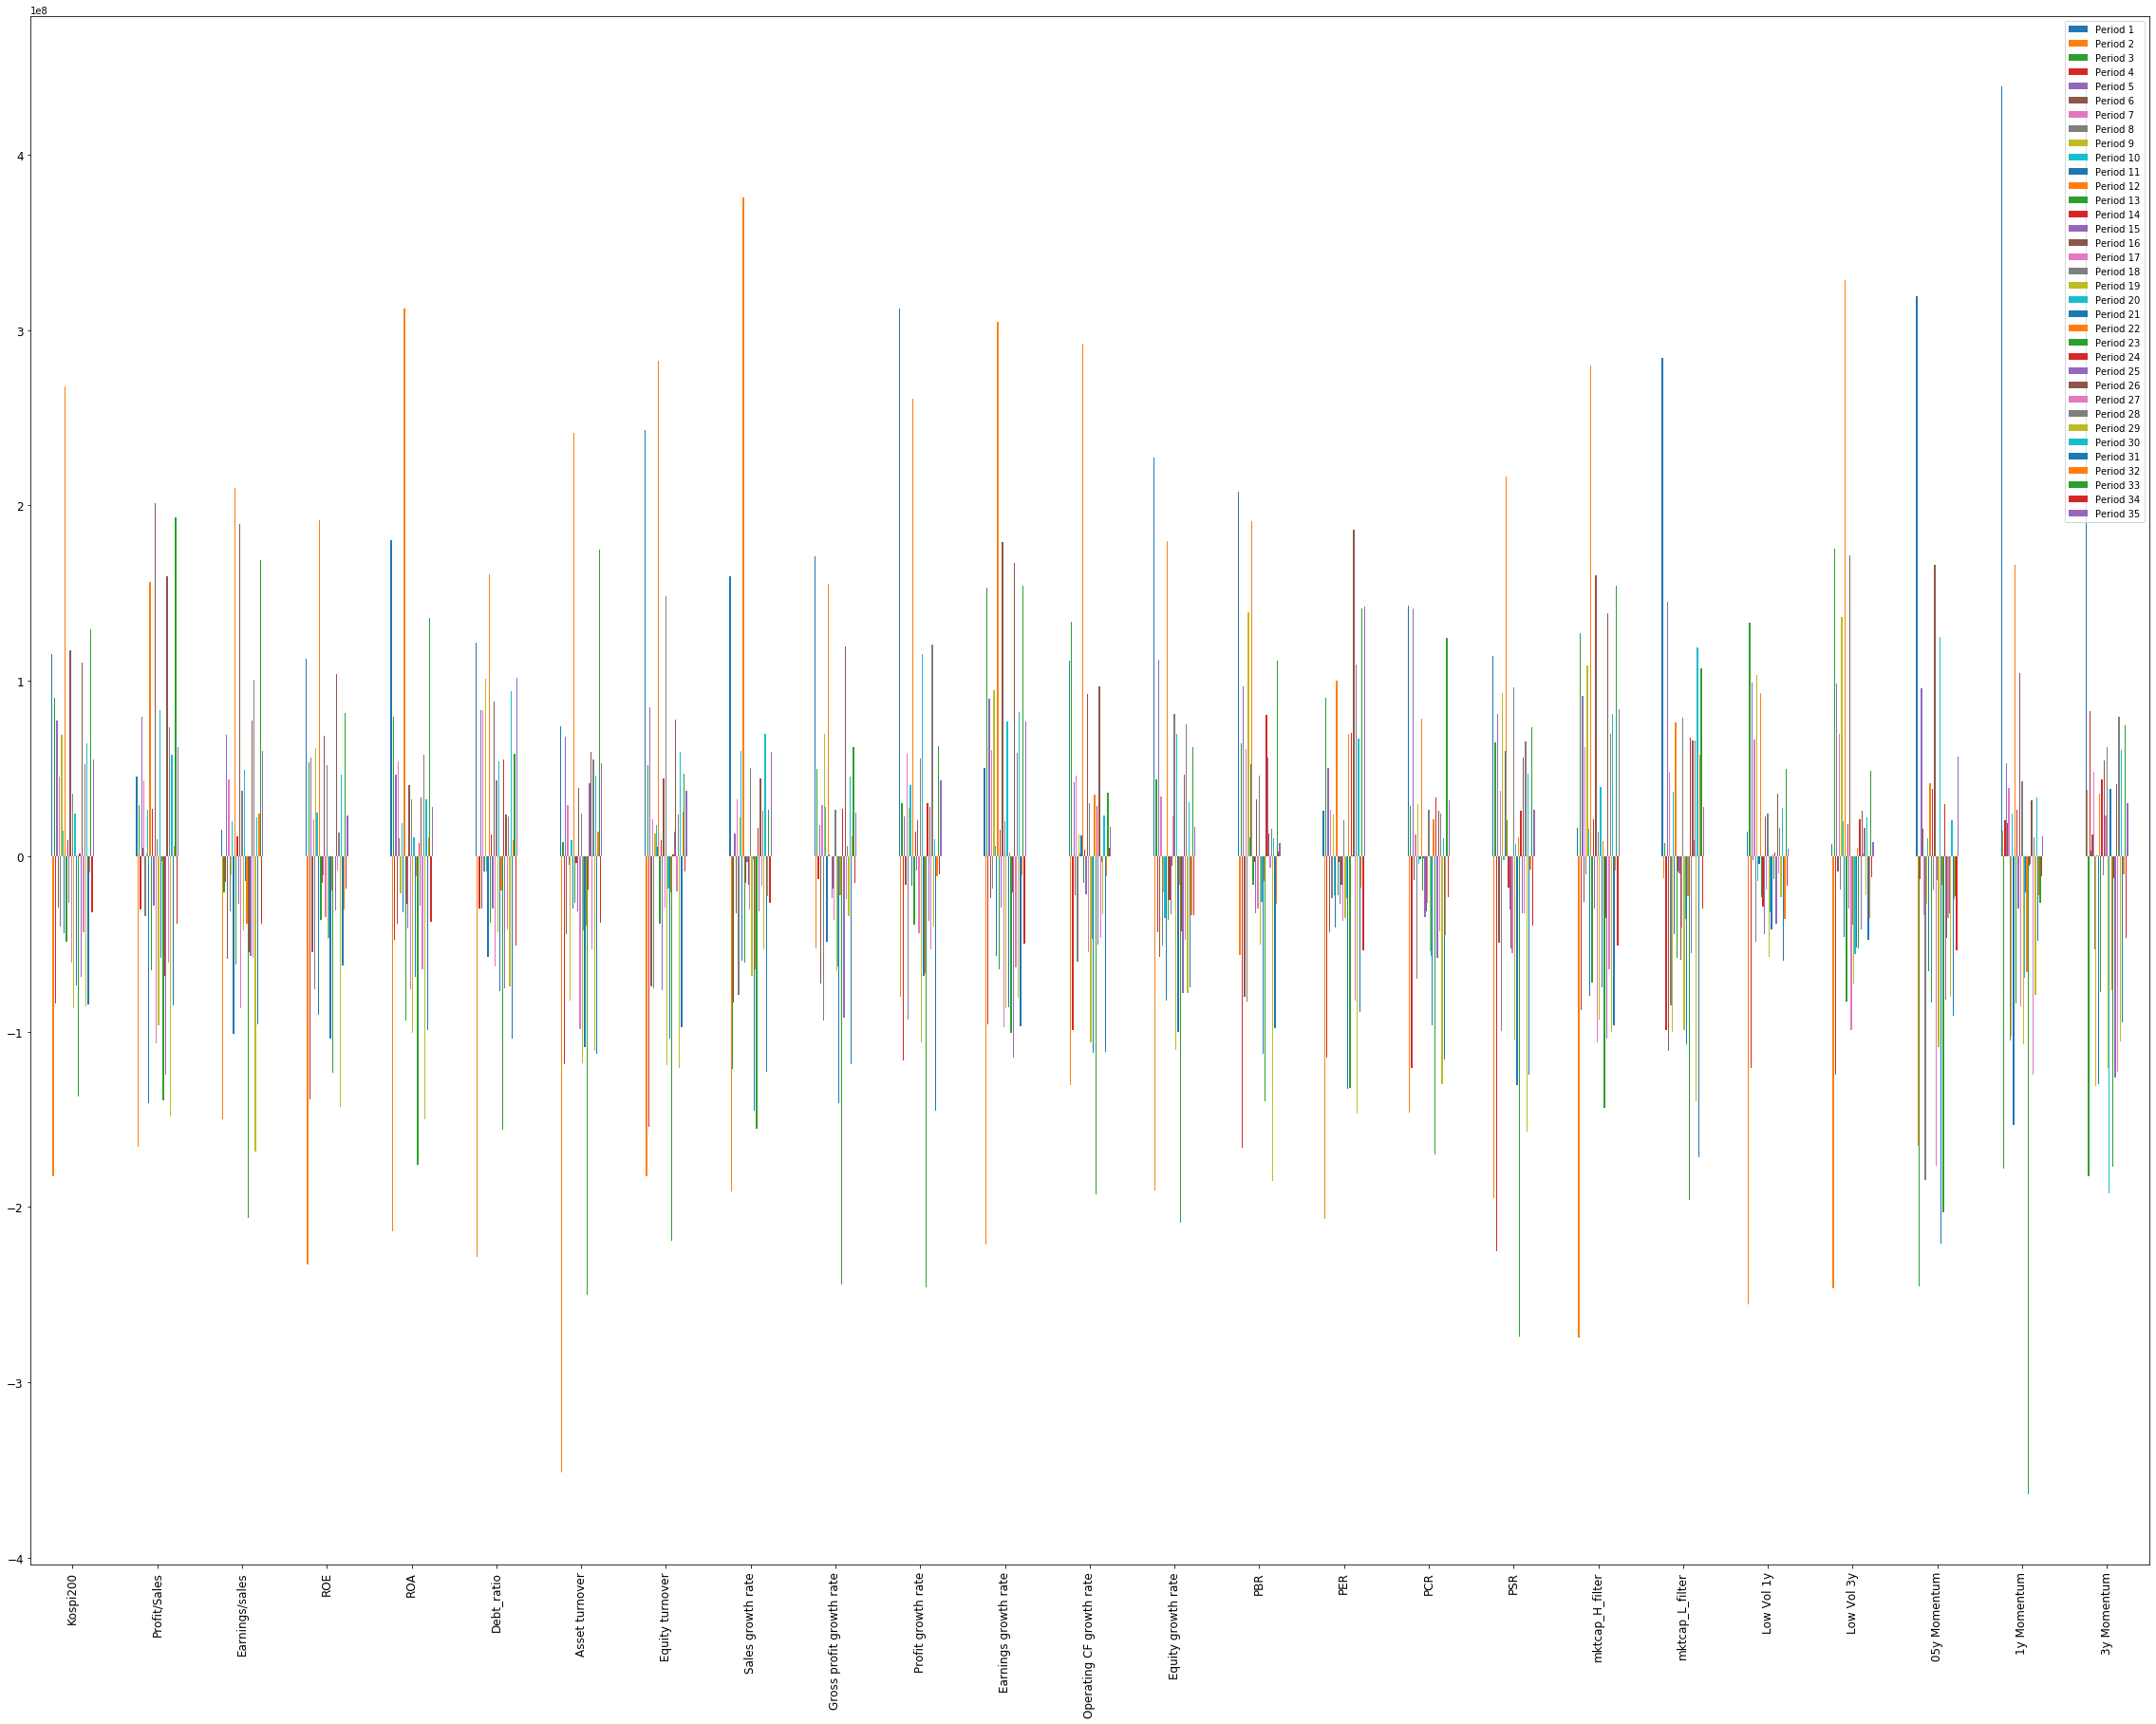

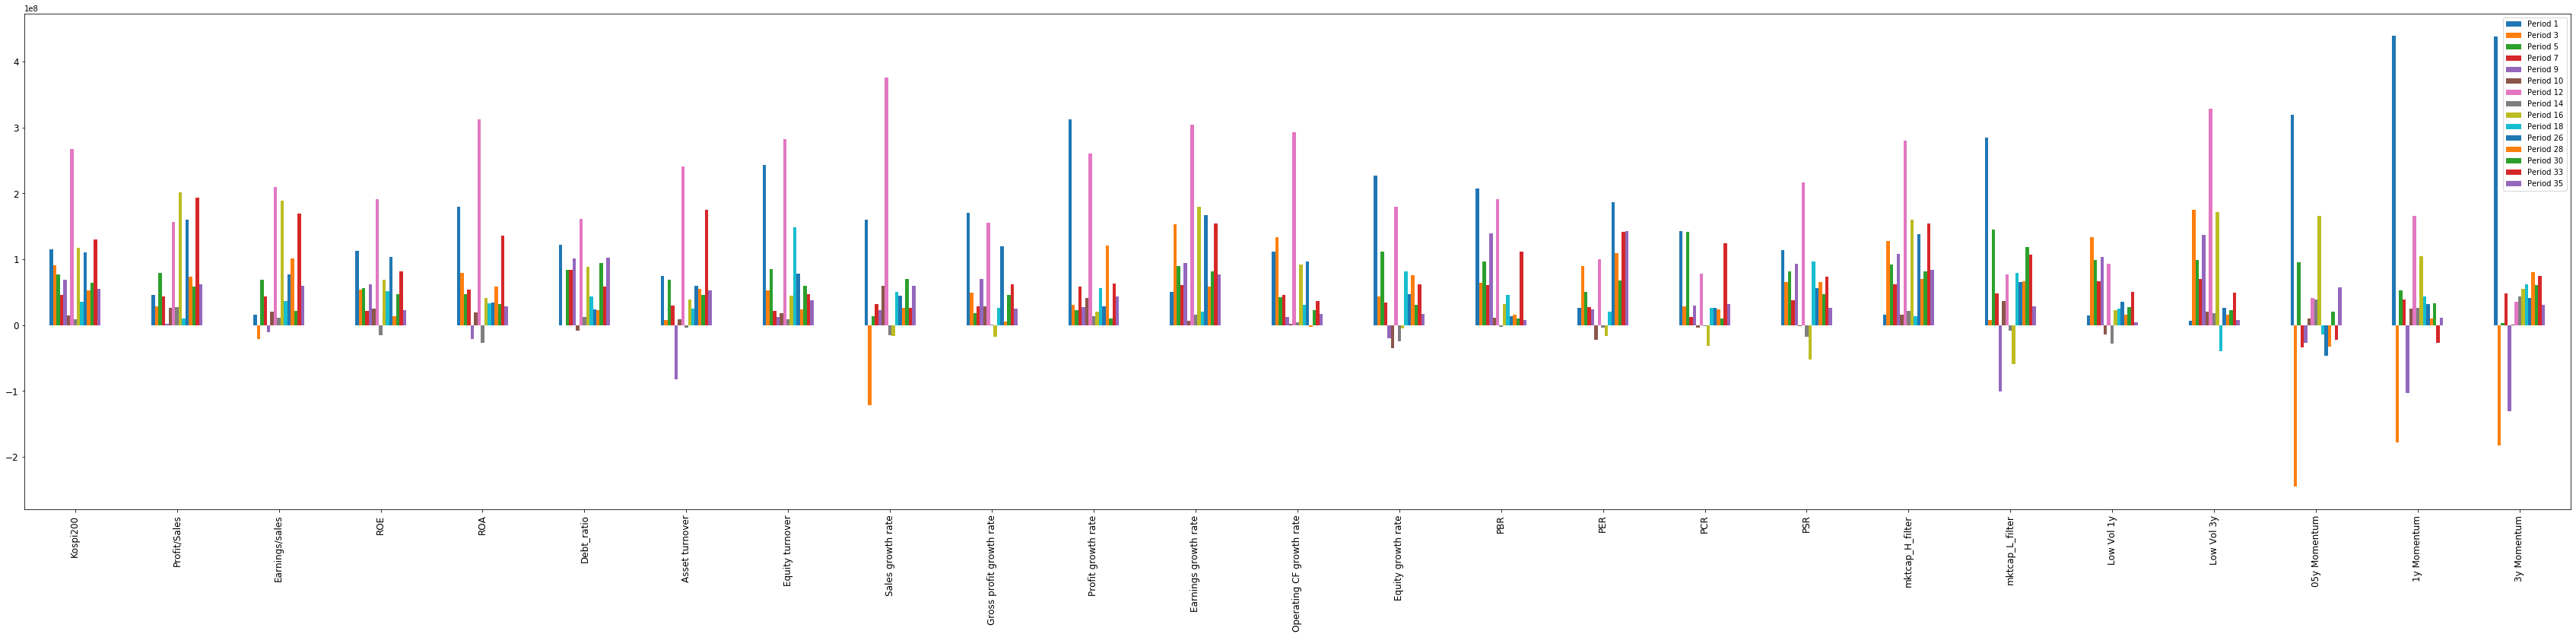

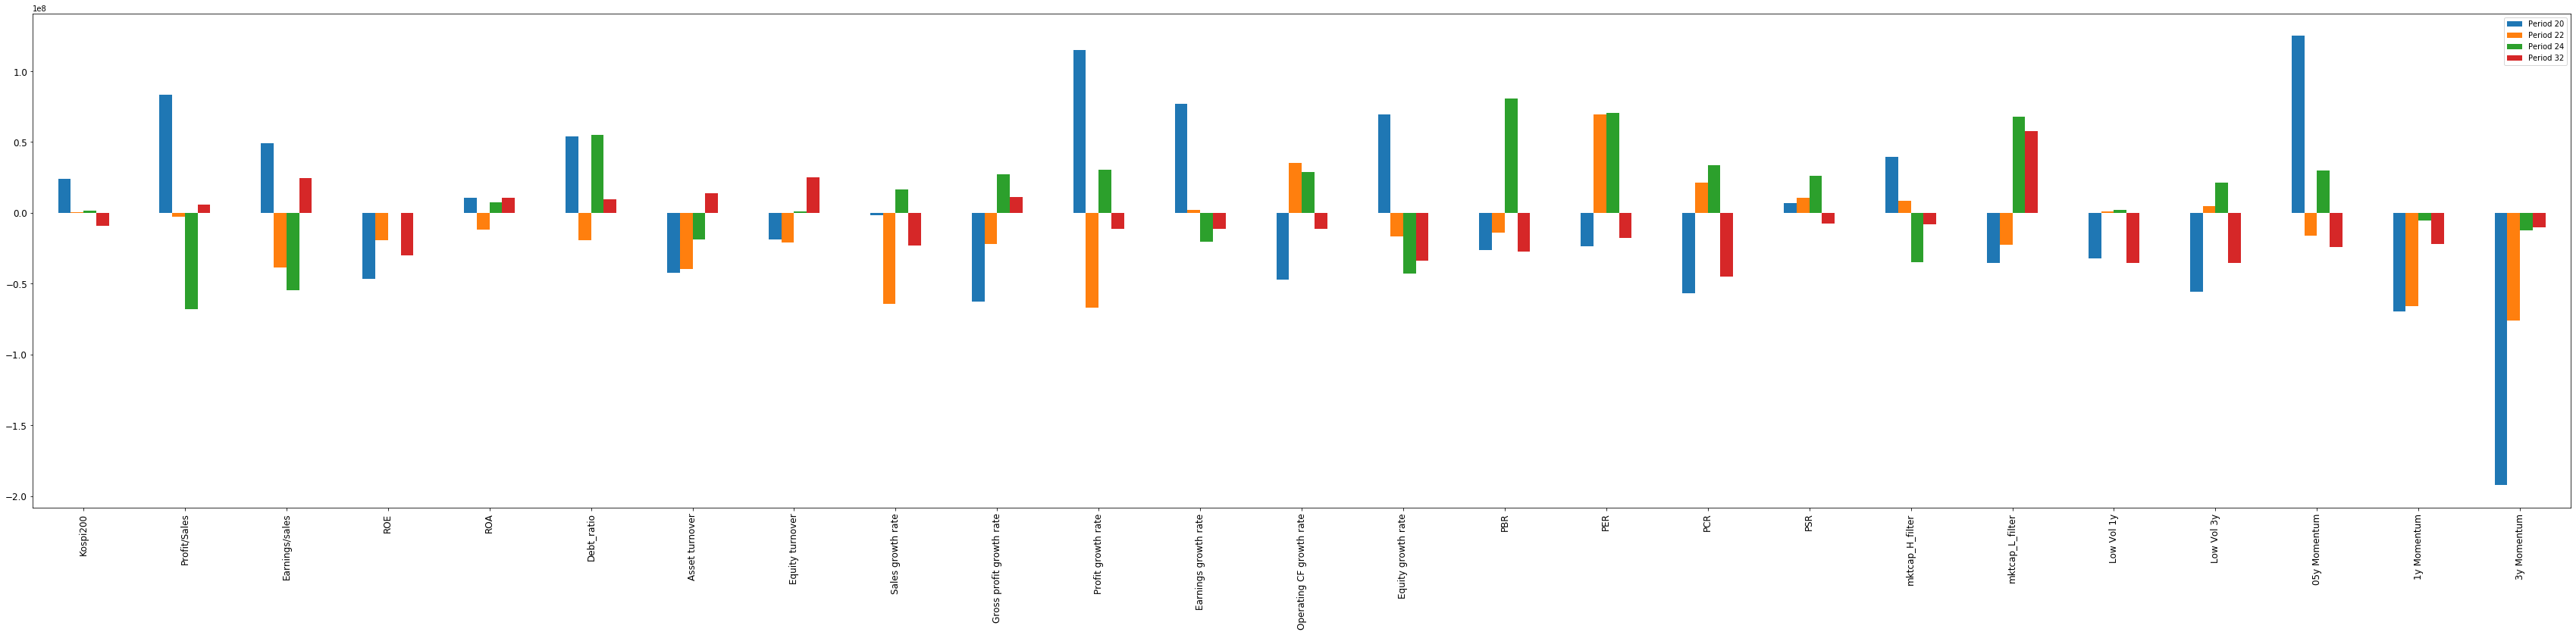

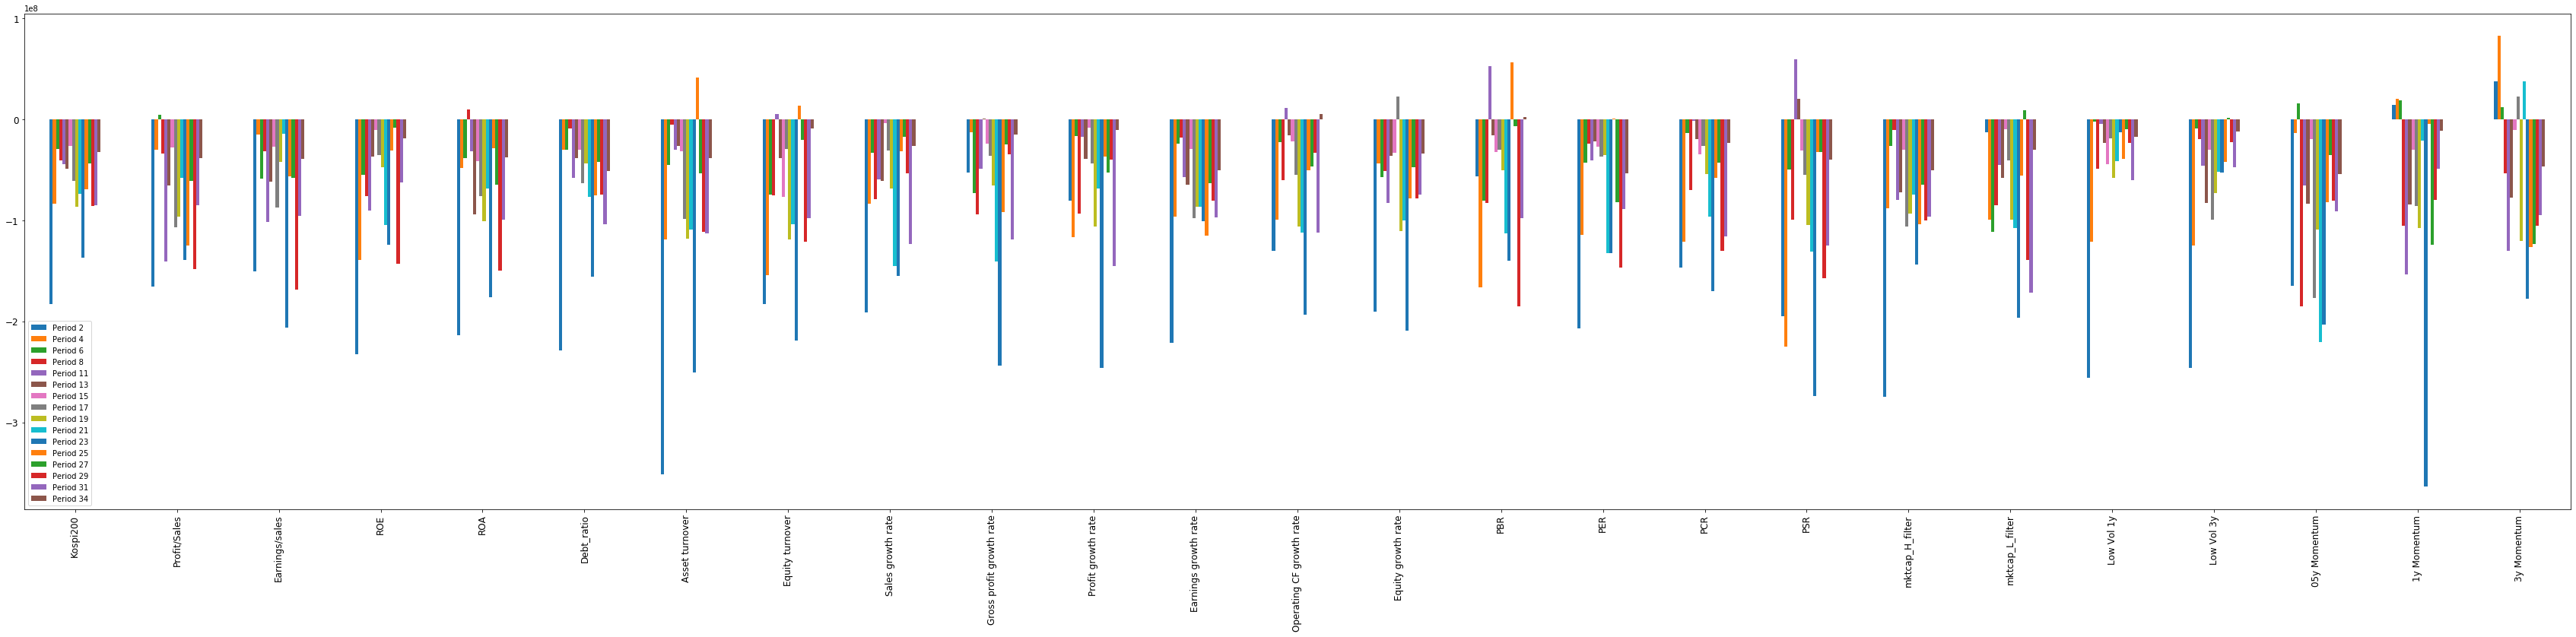

In [ ]:
#필터 백테스트 비주얼라이제이션

bars=pd.concat((p1_filter,p2_filter,p3_filter,p4_filter,p5_filter,p6_filter,p7_filter,p8_filter,p9_filter
                ,p10_filter,p11_filter,p12_filter,p13_filter,p14_filter,p15_filter,p16_filter,p17_filter,p18_filter
                ,p19_filter,p20_filter,p21_filter,p22_filter,p23_filter,p24_filter,p25_filter,p26_filter,p27_filter
                ,p28_filter,p29_filter,p30_filter,p31_filter,p32_filter,p33_filter,p34_filter,p35_filter),axis=1)
bars.columns=["Period 1","Period 2","Period 3","Period 4","Period 5","Period 6","Period 7","Period 8","Period 9"
              ,"Period 10","Period 11","Period 12","Period 13","Period 14","Period 15","Period 16","Period 17","Period 18"
              ,"Period 19","Period 20]
bars.plot.bar(figsize=(40,30),fontsize=12)


bars_up=bars[["Period 1","Period 3","Period 5","Period 7","Period 9","Period 10","Period 12","Period 14","Period 16","Period 18"]]
bars_up.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_up.png", bbox_inches = "tight")
files.download("bars_up.png") 

bars_side=bars[["Period 20"]]
bars_side.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_side.png", bbox_inches = "tight")
files.download("bars_side.png") 

bars_down=bars[["Period 2","Period 4","Period 6","Period 8","Period 11","Period 13","Period 15","Period 17","Period 19"]]
bars_down.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_down.png", bbox_inches = "tight")
files.download("bars_down.png") 


In [ ]:
#우량필터 선정
up_rank=pd.DataFrame(len(bars_up)-np.argsort(np.argsort(np.mean(bars_up,axis=1),axis=0)))
side_rank=pd.DataFrame(len(bars_side)-np.argsort(np.argsort(np.mean(bars_side,axis=1),axis=0)))
down_rank=pd.DataFrame(len(bars_down)-np.argsort(np.argsort(np.mean(bars_down,axis=1),axis=0)))

ranks=pd.concat((up_rank,side_rank,down_rank),axis=1)
ranks=pd.concat((ranks,np.sum(ranks,axis=1)),axis=1)
ranks=pd.concat((ranks,1+np.argsort(np.argsort(ranks.iloc[:,-1]))),axis=1)
ranks.columns=["ups","sides","downs","sum","total rank"]
ranks.sort_values("total rank")

,ups,sides,downs,sum,total rank
Profit growth rate,6,2,7,15,1
Debt_ratio,11,3,8,22,2
Kospi200,3,10,10,23,3
PBR,9,11,3,23,4
Earnings growth rate,1,6,19,26,5
PER,12,4,13,29,6
Low Vol 3y,7,20,4,31,7
Profit/Sales,4,8,21,33,8
ROA,8,9,18,35,9
mktcap_H_filter,2,12,22,36,10


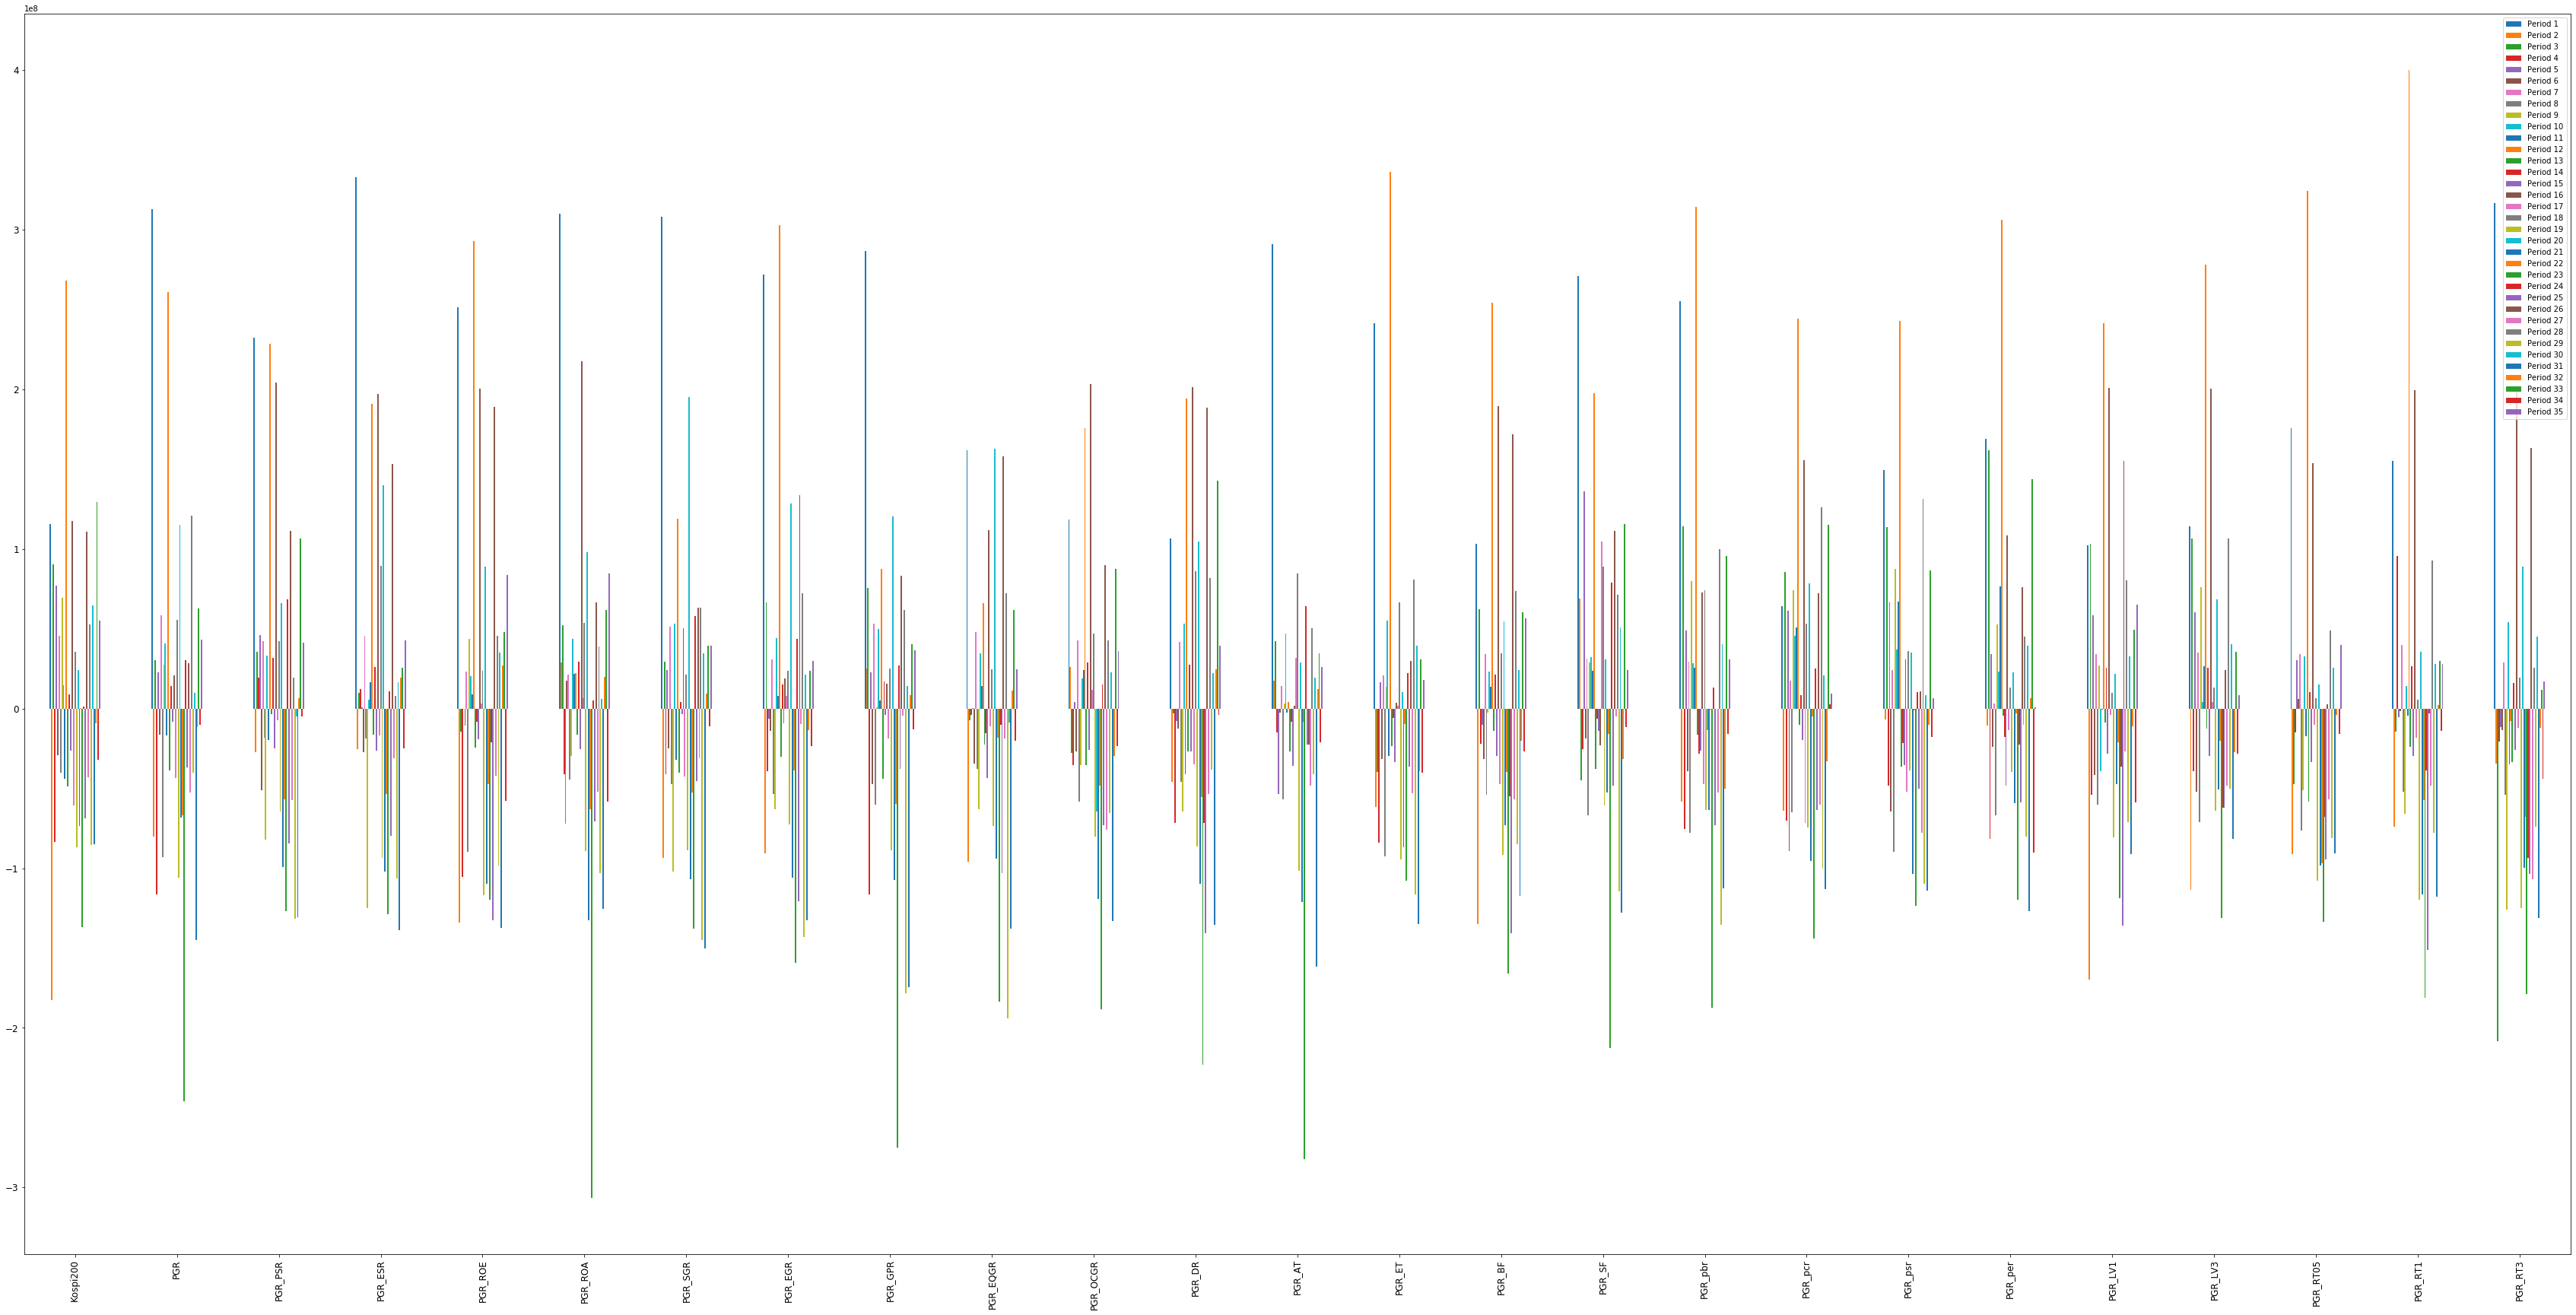

In [ ]:
#합성 필터 비주얼라이제이션

bars_PGR=pd.concat((p1_filter_PGR
                    ,p2_filter_PGR
                    ,p3_filter_PGR
                    ,p4_filter_PGR
                    ,p5_filter_PGR
                    ,p6_filter_PGR
                    ,p7_filter_PGR
                    ,p8_filter_PGR
                    ,p9_filter_PGR
                    ,p10_filter_PGR
                    ,p11_filter_PGR
                    ,p12_filter_PGR
                    ,p13_filter_PGR
                    ,p14_filter_PGR
                    ,p15_filter_PGR
                    ,p16_filter_PGR
                    ,p17_filter_PGR
                    ,p18_filter_PGR
                    ,p19_filter_PGR
                    ,p20_filter_PGR),axis=1)
bars_PGR.columns=["Period 1","Period 2","Period 3","Period 4","Period 5","Period 6","Period 7","Period 8","Period 9"
              ,"Period 10","Period 11","Period 12","Period 13","Period 14","Period 15","Period 16","Period 17","Period 18","Period 19","Period 20"]
bars_PGR.plot.bar(figsize=(60,30),fontsize=12)


bars_PGR_up=bars_PGR[["Period 1","Period 3","Period 5","Period 7","Period 9","Period 10","Period 12","Period 14","Period 16","Period 18"]]
bars_PGR_up.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_PGR_up.png", bbox_inches = "tight")
files.download("bars_PGR_up.png") 

bars_PGR_side=bars_PGR[["Period 20"]]
bars_PGR_side.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_PGR_side.png", bbox_inches = "tight")
files.download("bars_PGR_side.png") 

bars_PGR_down=bars_PGR[["Period 2","Period 4","Period 6","Period 8","Period 11","Period 13","Period 15","Period 17","Period 19"]]
bars_PGR_down.plot.bar(figsize=(60,12),fontsize=12)
plt.savefig("bars_PGR_down.png", bbox_inches = "tight")
files.download("bars_PGR_down.png") 


In [ ]:
#합성 필터 성과표

bars_PGR_up_outperform=(np.subtract(bars_PGR_up,bars_up.iloc[:1,:])>0)+0
bars_PGR_up_outperform=pd.concat((bars_PGR_up_outperform,np.sum(bars_PGR_up_outperform,axis=1)),axis=1)
bars_PGR_up_outperform.columns=list(bars_PGR_up_outperform.columns)[:-1]+["SUM"]
bars_PGR_up_outperform.sort_values("SUM", ascending = False)

bars_PGR_side_outperform=(np.subtract(bars_PGR_side,bars_side.iloc[:1,:])>0)+0
bars_PGR_side_outperform=pd.concat((bars_PGR_side_outperform,np.sum(bars_PGR_side_outperform,axis=1)),axis=1)
bars_PGR_side_outperform.columns=list(bars_PGR_side_outperform.columns)[:-1]+["SUM"]
bars_PGR_side_outperform.sort_values("SUM", ascending = False)

bars_PGR_down_outperform=(np.subtract(bars_PGR_down,bars_down.iloc[:1,:])>0)+0
bars_PGR_down_outperform=pd.concat((bars_PGR_down_outperform,np.sum(bars_PGR_down_outperform,axis=1)),axis=1)
bars_PGR_down_outperform.columns=list(bars_PGR_down_outperform.columns)[:-1]+["SUM"]
bars_PGR_down_outperform.sort_values("SUM", ascending = False)

,Period 2,Period 4,Period 6,Period 8,Period 11,Period 13,Period 15,Period 17,Period 19,Period 21,Period 23,Period 25,Period 27,Period 29,Period 31,Period 34,SUM
PGR_LV3,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,14
PGR_SGR,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,14
PGR_LV1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,14
PGR_SF,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,14
PGR_AT,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,13
PGR_pbr,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,13
PGR_ROE,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,13
PGR_EGR,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,13
PGR_GPR,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,13
PGR_EQGR,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,13


In [ ]:
#선정 종목 표시

df_krx = fdr.StockListing('KRX')
df_krx.index=df_krx.iloc[:,0];df_krx=df_krx.iloc[:,1:]

up_filter_select=[]
side_filter_select=[PGR_AT_filter,PGR_PSR_filter,PGR_ESR_filter,PGR_ROA_filter,PGR_SGR_filter,PGR_GPR_filter]
down_filter_select=[PGR_LV3_filter,PGR_SF_filter,PGR_per_filter,PGR_ESR_filter,PGR_PSR_filter,PGR_SGR_filter,PGR_EGR_filter,PGR_LV1_filter,profit_gr_filter,PGR_OCGR_filter,PGR_DR_filter,PGR_AT_filter,PGR_EQGR_filter,PGR_psr_filter]


top_filter00=up_filter_select+side_filter_select+down_filter_select
top_filter0=top_filter00[0].iloc[:1,:]+0
if len(top_filter00)>1:
  for i in range(len(top_filter00)-1):
    top_filter0=pd.concat((top_filter0,top_filter00[i+1].iloc[:1,:]),axis=0)+0
else:
  top_filter0=top_filter0=top_filter00[0].iloc[:1,:]+0
#top_filter0=pd.concat((per_filter.iloc[:1,:],PER_PSR_filter.iloc[:1,:],PER_ESR_filter.iloc[:1,:],PER_BF_filter.iloc[:1,:],PER_RT3_filter.iloc[:1,:],PER_ROA_filter.iloc[:1,:],PER_DR_filter.iloc[:1,:],PER_EGR_filter.iloc[:1,:],PER_AT_filter.iloc[:1,:],PER_PGR_filter.iloc[:1,:],PER_ET_filter.iloc[:1,:]),axis=0)+0
top_filter1=pd.concat((top_filter0,pd.DataFrame(np.sum(top_filter0.iloc[:,:],axis=0)).T))
top_filter2=pd.concat((top_filter1,mktcap.iloc[:1,:]),axis=0)
top_filter2.index=np.arange(len(top_filter2.index))
top_filter=(top_filter2.T).sort_values(top_filter2.index[-2], ascending = False)
blacklist=[]
today_top=(top_filter.drop(blacklist)).iloc[:]
today_top_result0=pd.concat((df_krx.loc[(today_top.index)[:]],today_top.iloc[:,-2:]),axis=1)
today_top_result=pd.concat(((((Close[today_top_result0.index]).iloc[:1,:]).T),today_top_result0),axis=1)
today_top_result.iloc[:20]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,2020-01-20 00:00:00,Name,Sector,Industry,20,21
170900,99200.0,동아에스티,의약품 제조업,"스티렌, 자이데나",14.0,8.376317e+11
060980,44150.0,한라홀딩스,기타 금융업,지주회사 및 경영컨설팅 서비스업,13.0,4.623419e+11
251270,94600.0,넷마블,소프트웨어 개발 및 공급업,온라인·모바일 게임 소프트웨어 개발 및 공급,12.0,8.111436e+12
271560,113000.0,오리온,기타 식품 제조업,스낵 등 과자류,10.0,4.467583e+12
049770,226500.0,동원F&B,기타 식품 제조업,"참치캔,음료,냉동식품 제조,판매",10.0,8.740916e+11
006840,34300.0,AK홀딩스,기타 금융업,지주사업,8.0,4.543913e+11
018250,31100.0,애경산업,기타 화학제품 제조업,"Age 20's,루나, 트리오, 2080치약, 순샘, 제트 등",7.0,8.213490e+11
010780,30350.0,아이에스동서,"내화, 비내화 요업제품 제조업","타일,위생도기,콘크리트파일,P.C관,침목 제조,도매",7.0,9.375906e+11
069260,19700.0,휴켐스,기타 화학제품 제조업,"화합물,화학제품 제조",7.0,8.053082e+11
000080,32050.0,하이트진로,알코올음료 제조업,소주,6.0,2.247782e+12
